In [20]:
# Installed torch-directml so that I can use my AMD gpu with torch
# also needed to downgrade my torch a little, to 2.4.1
import torch
import torch_directml
dml = torch_directml.device()
import numpy as np


Complete


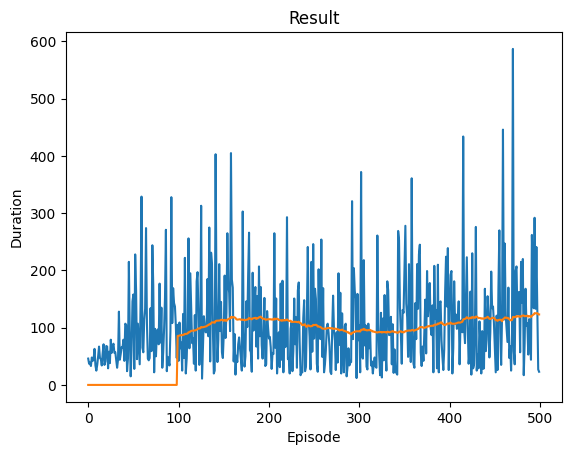

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from env2048.env2048 import Env2048

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if GPU is to be used
# TODO here is where I could swap for torch_directml
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        # TODO wondering if it would be worth try to add a convolutional layer for one experiment?
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

env = Env2048(3, 3, 6)
n_actions = 4
# Get the number of state observations
state = env.reset()
n_observations = state.size

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

# TODO probably want to switch this to softmax?
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randint(0,3)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# --- learning
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 500

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    print(f"episode: {i_episode}")
    state = env.reset()
    state = torch.tensor(state.flatten(), dtype=torch.float, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        stat_obs, reward, score, end, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if end:
            next_state = None
        else:
            next_state = torch.tensor(stat_obs.flatten(), dtype=torch.float, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if end:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.show()

In [3]:
import numpy as np

temp = np.zeros((4,3,3))
temp[0,2,2] = 4
temp[1,1,1] = 20
temp[2,0,2] = 1
np.max(np.nonzero(temp))

np.int64(2)

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class DQN_thin_long(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN_thin_long, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 64)
        self.layer5 = nn.Linear(64, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)

class DQN_extra_thin(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN_extra_thin, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 32)
        self.layer5 = nn.Linear(32, 32)
        self.layer6 = nn.Linear(32, 32)
        self.layer7 = nn.Linear(32, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        x = F.relu(self.layer6(x))
        return self.layer7(x)

# :/ I'd have to rewrite the agent to get this to work    
class DQN_cnn(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN_cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_actions)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

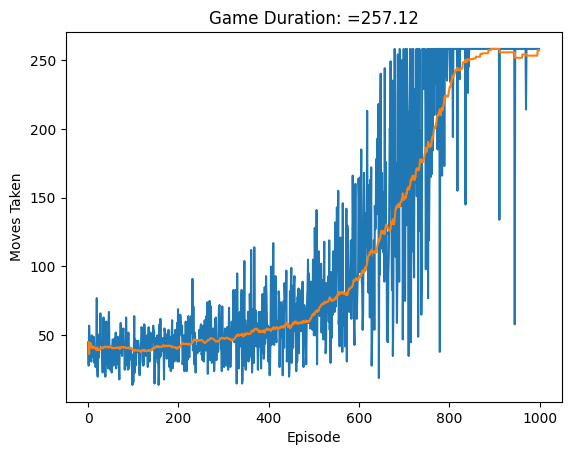

<Figure size 640x480 with 0 Axes>

Complete
Buffer Full: 244
Decay Done: 439


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from itertools import count

import torch
import torch_directml
dml = torch_directml.device(torch_directml.default_device())
from dqn_agent.basic_dqn import DQN, BasicDQN
from metrics import Metrics
from env2048.env2048 import Env2048
import env2048.rewards as rewards
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

def combined_reward(
    old_grid, action, new_grid, tot_merged, score, end, win, num_moves
) -> float:
    reward = 0
    reward += rewards.reward_win(old_grid, action, new_grid, tot_merged, score, end, win, num_moves) * 100
    reward += rewards.penalize_moves(old_grid, action, new_grid, tot_merged, score, end, win, num_moves) * .1
    return reward

# device = dml
# env = Env2048(3, 3, 6, combined_reward, onehot_enc=True)
env = Env2048(3, 3, 6, rewards.reward_max_tile, onehot_enc=True)
e_decay = 10000
buffer_size = 10000
num_episodes = 800
dim = env.get_grid_dim()
state_dim = dim[0]*dim[1]*dim[2]
agent = BasicDQN(dqn_module=DQN_thin_long, torch_device=device, observations_in_state=state_dim, buffer_size=buffer_size, batch_size=128, e_start=.95, e_end=.01, e_decay=e_decay, update_rate=.0005)
metrics = Metrics()

sum_steps = 0
decay_done = 0
buffer_full = 0
max_episode_steps = 256

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state.flatten(), dtype=torch.float, device=device).unsqueeze(0)
    for t in count():
        state, action, next_state, reward, score, high_tile, end, win = agent.act_and_learn(state, env)

        if end: # or t > max_episode_steps:
            sum_steps += t
            if decay_done == 0 and sum_steps > e_decay:
                decay_done = i_episode
            if buffer_full == 0 and sum_steps > buffer_size:
                buffer_full = i_episode                
            display.clear_output(wait=True)
            metrics.add_episode(1 if win else 0, reward, score, t+1, high_tile)
            metrics.plot_steps()
            break


print('Complete')
print(f"Buffer Full: {buffer_full}")
print(f"Decay Done: {decay_done}")
# 14.5 minutes
# ~20 for extra thin

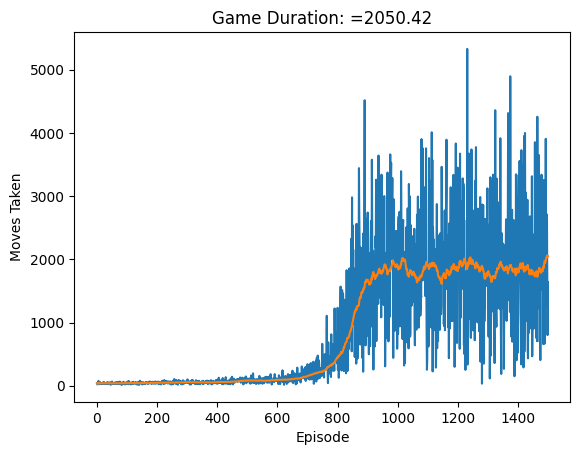

<Figure size 640x480 with 0 Axes>

Complete
Buffer Full and Decay done: [(414, 232), (429, 242), (427, 239), (433, 238), (422, 233), (428, 245), (417, 232), (431, 239), (425, 235), (422, 236)]


<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from itertools import count

import torch
import torch_directml
dml = torch_directml.device(torch_directml.default_device())
from dqn_agent.basic_dqn import DQN, BasicDQN
from metrics import Metrics
from env2048.env2048 import Env2048
import env2048.rewards as rewards
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

def combined_reward(
    old_grid, action, new_grid, tot_merged, score, end, win, num_moves
) -> float:
    reward = 0
    reward += rewards.reward_max_tile(old_grid, action, new_grid, tot_merged, score, end, win, num_moves)
    reward += rewards.penalize_loss(old_grid, action, new_grid, tot_merged, score, end, win, num_moves) * 5
    return reward

env = Env2048(3, 3, 6, rewards.reward_max_tile, onehot_enc=True)
e_decay = 20000
buffer_size = 10000
num_episodes = 1500
dim = env.get_grid_dim()
state_dim = dim[0]*dim[1]*dim[2]
num_agents = 10
all_metrics = []
decay_buffer = []
for x in range(num_agents):
    agent = BasicDQN(dqn_module=DQN_thin_long, torch_device=device, observations_in_state=state_dim, buffer_size=buffer_size, batch_size=128, e_start=.95, e_end=.01, e_decay=e_decay, update_rate=.0005)
    all_metrics.append(Metrics())

    sum_steps = 0
    decay_done = 0
    buffer_full = 0

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state = env.reset()
        state = torch.tensor(state.flatten(), dtype=torch.float, device=device).unsqueeze(0)
        for t in count():
            state, action, next_state, reward, score, high_tile, end, win = agent.act_and_learn(state, env)

            if end: # or t > max_episode_steps:
                sum_steps += t
                if decay_done == 0 and sum_steps > e_decay:
                    decay_done = i_episode
                if buffer_full == 0 and sum_steps > buffer_size:
                    buffer_full = i_episode                
                display.clear_output(wait=True)
                all_metrics[x].add_episode(1 if win else 0, reward, score, t+1, high_tile)
                all_metrics[x].plot_steps()
                break
    decay_buffer.append((decay_done, buffer_full))


print('Complete')
print(f"Buffer Full and Decay done: {decay_buffer}")

8


In [8]:
import numpy as np
from metrics import Metrics
import torch
# for m in range(len(all_metrics)):
#     all_metrics[m].save_to_file(f"tmp/{m}_metric.csv")
all_metrics = []
for m in range(10):
    met = Metrics()
    met.read_from_file(f"tmp/{m}_metric.csv")
    met.rewards = np.zeros((len(met.rewards),))
    all_metrics.append(met)

c:\dev\code\Fall24\RL\Project\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\dev\code\Fall24\RL\Project\venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


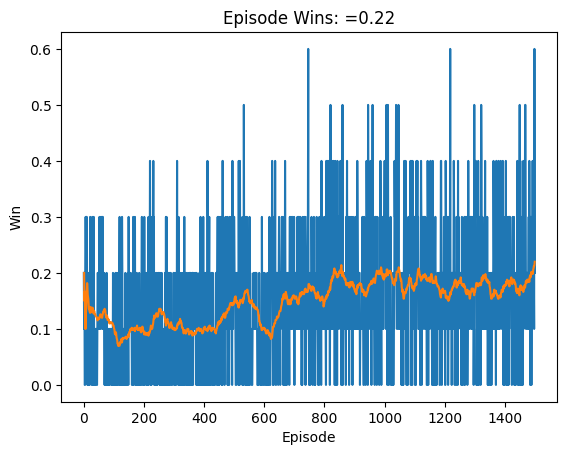

<Figure size 640x480 with 0 Axes>

[424.8 237.1]


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
avg_metric = Metrics.average(all_metrics)
# avg_metric.save_to_file("dqn_logs/18_avg_20kdecay_5kbuffer.csv") # decay done 425.1, buffer full 124.9
# avg_metric.save_to_file("dqn_logs/19_8avg_20kdecay_5kbuffer_2kepisodes.csv") # decay done 424.375, buffer full 236.625 (actually 10k buffer)
avg_metric.save_to_file("dqn_logs/20_avg_20kdecay_10kbuffer_15kepisodes.csv") # decay done 424.8, buffer full 237.1 (with loss penalty)
avg_metric.plot_winrate()
allDone = np.array([0,0])
for k in range(len(decay_buffer)):
    allDone[0] += decay_buffer[k][0]
    allDone[1] += decay_buffer[k][1]
allDone = allDone/len(decay_buffer)
print(allDone)

c:\dev\code\Fall24\RL\Project\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\dev\code\Fall24\RL\Project\venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


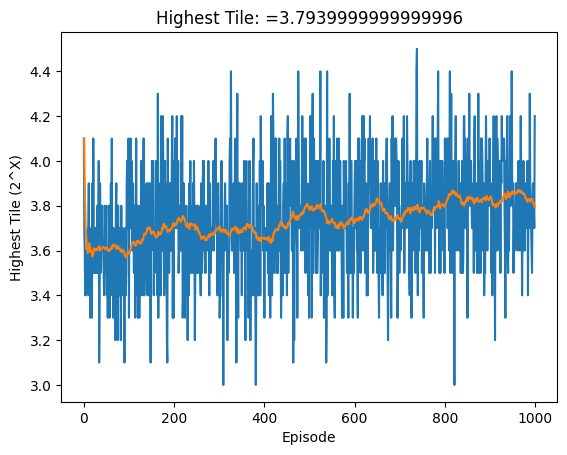

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
avg_metric.plot_hightile()

In [4]:
metrics.save_to_file("dqn_logs/17_limit256.csv") # 


c:\dev\code\Fall24\RL\Project\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\dev\code\Fall24\RL\Project\venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


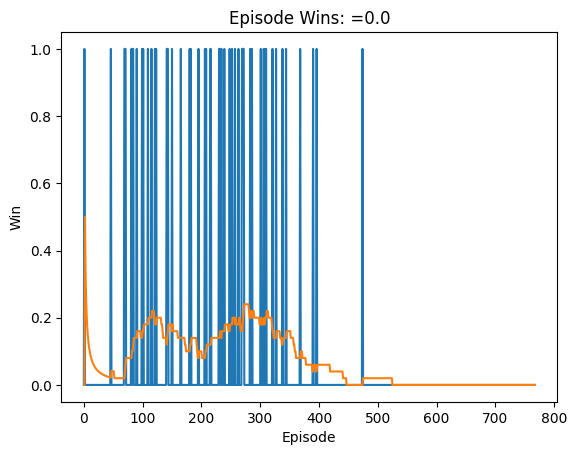

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
from metrics import Metrics
m = Metrics()
# m.read_from_file("dqn_logs/01_dqn_base_500.csv")
# m.read_from_file("dqn_logs/02_dqn_better_r_500.csv") # decay_done at 98, buffer_full at 147
# m.read_from_file("dqn_logs/03_dqn_decayBuf_swap_500.csv") # decay_done at 218, buffer_full at 124 (buffer=5K, decay=10K)
# m.read_from_file("dqn_logs/04_dqn_500.csv") # decay_done at 216, buffer_full at 216 (buffer=10K, decay=10K)
# m.read_from_file("dqn_logs/05_dqn_800.csv") # decay_done at 207, buffer_full at 207 (buffer=10K, decay=10K)
# m.read_from_file("dqn_logs/06_dqn_change_r_500.csv") # decay_done at 104, buffer_full at 154 (buffer=10K, decay=5K, r- removed penalty,merge, add high tile)
# m.read_from_file("dqn_logs/07_dqn_thin_long_500.csv") # decay_done at 108, buffer_full at 159 (buffer=10K, decay=5K, thin_long DQN)
# m.read_from_file("dqn_logs/08_dqn_extra_thin_500.csv") # decay_done at 108, buffer_full at 155 (buffer=10K, decay=5K, extra_thin DQN)
# m.read_from_file("dqn_logs/09_dqn_rpenalty_extra_500.csv") # decay_done at 108, buffer_full at 155 (-.1 move penalty, extra_thin DQN)
# m.read_from_file("dqn_logs/10_dqn_only_finalr_500.csv") # decay_done at 104, buffer_full at 154 (only end r, thin_long DQN)
# m.read_from_file("dqn_logs/11_dqn_100r_500.csv") # decay_done at 107, buffer_full at 165 (only end r 100, thin_long DQN)
# m.read_from_file("dqn_logs/12_dqn_100r_wpenalty_500.csv") # decay_done at 100, buffer_full at 155 (end r 100 w/penalty, thin_long DQN)
# m.read_from_file("dqn_logs/13_dqn_onehot_maxr_500.csv") # decay_done at 108, buffer_full at 165 (after merge (also 512 step/episode limit), thin_long DQN)
# m.read_from_file("dqn_logs/14_dqn_onehot_maxr_nolimit_500.csv") # decay_done at 104, buffer_full at 158 (no episode limit, thin_long DQN)
# m.read_from_file("dqn_logs/15_dqn_winr_500.csv") # decay_done at 107, buffer_full at 161 (win reward, thin_long DQN)
# m.read_from_file("dqn_logs/16_win-loss-movePenalty_500.csv") # decay_done at 107, buffer_full at 158 (win reward, thin_long DQN)
m.read_from_file("dqn_logs/17_limit256.csv") # (new max tile r, limit 256, thin_long DQN)
# m.plot_steps()
m.plot_winrate()

In [10]:
import numpy as np
env = Env2048(3, 3, 6, rewards.reward_win, onehot_enc=True)
metrics = Metrics()
for i_episode in range(num_episodes):
        # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state.flatten(), dtype=torch.float, device=device).unsqueeze(0)
    for t in count():
        stat_obs, reward, score, end, win = env.step(np.random.randint(0,4))

        if end:# or t > max_episode_steps:
            sum_steps += t            
            display.clear_output(wait=True)
            metrics.add_episode(1 if win else 0, reward, score, t+1, 0)
            metrics.plot_steps()
            break

NameError: name 'Env2048' is not defined

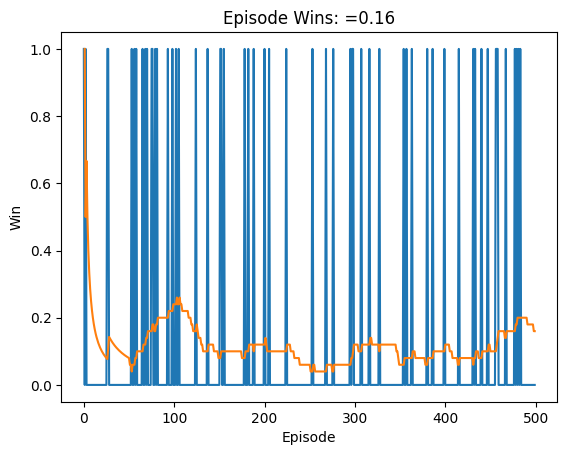

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
metrics.plot_winrate()